In [9]:
import glob
import re
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.table import Table
import dja_sepp

In [24]:
home = "/FlashStorage/DJA-SEpp"
field = 'ceers-full-grizli-v7.2'
with fits.open(glob.glob(f"{home}/fields/{field}/catalog/dja/*fix_phot_apcorr.fits")[0]) as hdul:
    phot_dja = Table(hdul[1].data)
phot_tiles = []
tiles = glob.glob(f"{home}/fields/{field}/sepp/*sci_cutout*tile-[!full]*sepp_cat.fits")
tiles.sort()
for tile in tiles:
    with fits.open(tile) as hdul:
        phot_tiles.append(Table(hdul[1].data))

In [26]:
print(f"{'Sources in DJA catalog':<28} : {len(phot_dja)}")
# print(phot_dja.keys())
for i, tile in enumerate(phot_tiles):
    print(f"{f'Sources in SE++ catalog ({i})':<28} : {len(tile)}")
    # print(len(tile.keys()))

Sources in DJA catalog       : 76637
Sources in SE++ catalog (0)  : 2111
Sources in SE++ catalog (1)  : 1691
Sources in SE++ catalog (2)  : 3744
Sources in SE++ catalog (3)  : 2063
Sources in SE++ catalog (4)  : 1639
Sources in SE++ catalog (5)  : 1650
Sources in SE++ catalog (6)  : 2032
Sources in SE++ catalog (7)  : 1787
Sources in SE++ catalog (8)  : 1821


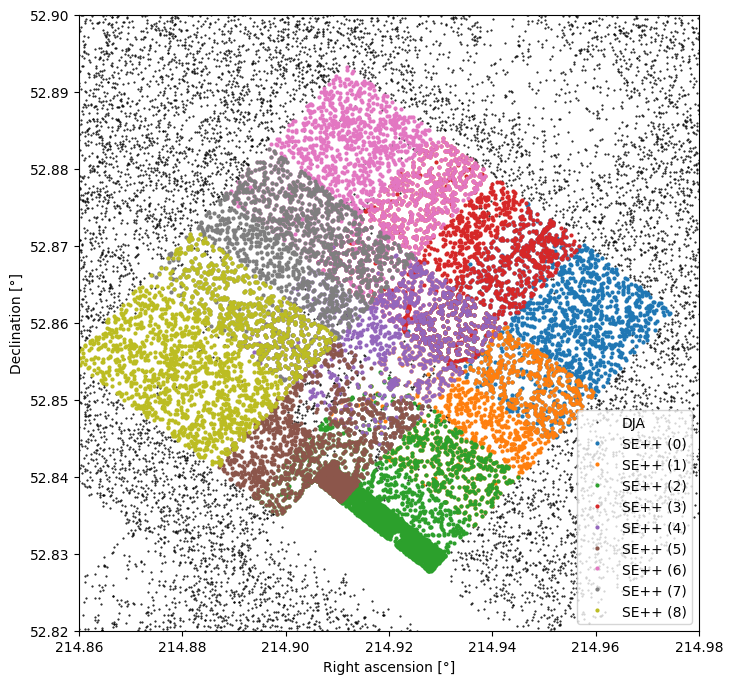

In [27]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phot_dja['ra'], phot_dja['dec'], marker='o', ls='', ms=0.5, c='k', label='DJA')
for i, tile in enumerate(phot_tiles):
    ax.plot(tile['world_centroid_alpha'], tile['world_centroid_delta'], marker='o', ls='', ms=2, label=f'SE++ ({i})')
ax.set_xlabel('Right ascension [°]')
ax.set_ylabel('Declination [°]')
ax.set_xlim(214.86, 214.98)
ax.set_ylim(52.82, 52.90)
ax.legend()
plt.show()

In [28]:
phot_full = dja_sepp.merge_tiles(phot_tiles)
name = re.sub('tile-\d+','tile-full',tiles[0].split('/')[-1])
phot_full.write(f"{home}/fields/{field}/sepp/{name}", format='fits', overwrite=True)

In [20]:
filter_list = dja_sepp.get_filter_list(phot_full.keys())
print("====== Resid =======")
dja_sepp.merge_images(f"{home}/fields/{field}/sepp/checkimages", filter_list, type='resid', verbose=True)
print("====== Model =======")
dja_sepp.merge_images(f"{home}/fields/{field}/sepp/checkimages", filter_list, type='model', verbose=True)
# print("====== Data ========")
# dja_sepp.merge_images(f"{home}/fields/{field}/image/cutout/tiles", filter_list, type='', verbose=True)

====== Resid =======
Finding optimal WCS
---- F115W ----
Mosaicing
Saving
---- F150W ----
Mosaicing
Saving
---- F200W ----
Mosaicing
Saving
---- F277W ----
Mosaicing
Saving
---- F356W ----
Mosaicing


KeyboardInterrupt: 

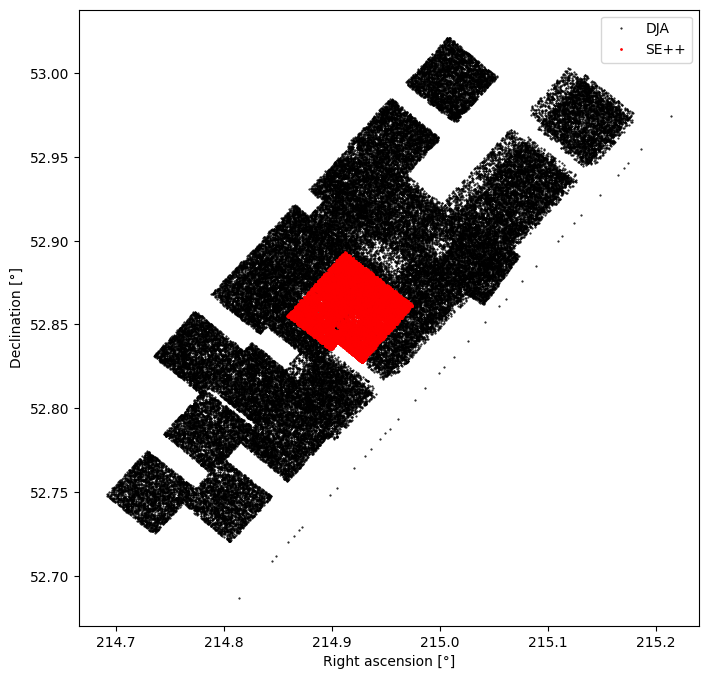

In [29]:
fig, ax = plt.subplots(figsize=(8,8))
ax.plot(phot_dja['ra'], phot_dja['dec'], marker='o', ls='', ms=0.5, c='k', label='DJA')
ax.plot(phot_full['world_centroid_alpha'], phot_full['world_centroid_delta'], marker='o', ls='', ms=1, c='r', label=f'SE++')
ax.set_xlabel('Right ascension [°]')
ax.set_ylabel('Declination [°]')
# ax.set_xlim(214.86, 214.98)
# ax.set_ylim(52.83, 52.90)
ax.legend()
plt.show()